In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

C:\Users\kwea123\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [441]:
class Episode_experience():
    def __init__(self):
        self.memory = {'states':[], 'actions':[], 'rewards':[], 'next_states':[], 'dones':[], 'goals':[]}
        
    def add(self, state, action, reward, next_state, done, goal):
        self.memory['states'] += [state]
        self.memory['actions'] += [action]
        self.memory['rewards'] += [reward]
        self.memory['next_states'] += [next_state]
        self.memory['dones'] += [done]
        self.memory['goals'] += [goal]
    
    def clear(self):
        for k in self.memory:
            self.memory[k] = []
        

class DQNAgent():
    def __init__(self, state_size, action_size, goal_size, double_dqn=True, clip_target_value=True, her=True):
        self.state_size = state_size
        self.goal_size = goal_size
        self.action_size = action_size
        self.double_dqn = double_dqn
        self.clip_target_value = clip_target_value
        self.memory = {'states':[], 'actions':[], 'rewards':[], 'next_states':[], 'dones':[], 'goals':[]}
        self.epsilon = 0.2 # exploration
        self.tau = 0.95 # target net update weight
        self.gamma = 0.98
        self.batch_size = 128
        self.learning_rate = 1e-3
        self.buffer_size = 1e6
        self.her = her # use HER or not
        self._set_model()
        
    def _set_model(self): # set value network
        tf.reset_default_graph()
        self.sess = tf.Session()
        
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.tfs_ = tf.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.tfg = tf.placeholder(tf.float32, [None, self.goal_size], 'goal')
        self.tfa = tf.placeholder(tf.int32, [None, ], 'action')
        self.tfr = tf.placeholder(tf.float32, [None, ], 'reward')
        self.tfd = tf.placeholder(tf.float32, [None, ], 'done')
        
        def _build_qnet(state, scope, trainable, reuse):
            with tf.variable_scope(scope, reuse=reuse):
                net = tf.layers.dense(tf.concat([state, self.tfg], axis=1), 256, activation=tf.nn.relu, trainable=trainable)
                q = tf.layers.dense(net, self.action_size, trainable=trainable)
            return q, tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
        
        self.q_eval, e_params = _build_qnet(self.tfs, 'eval', trainable=True, reuse=True)
        self.q_targ, t_params = _build_qnet(self.tfs_, 'target', trainable=False, reuse=False)
        
        self.update_op = [tf.assign(t, self.tau*e+(1.self.tau)*t) for t, e in zip(t_params, e_params)] # soft update
        
        self.choose_action_op = tf.argmax(self.q_eval, axis=1)
        
#         self.q_target = tf.placeholder(tf.float32, [None, ], 'q_target')
        if self.double_dqn:
            q_eval_next, _ = _build_qnet(self.tfs_, 'eval', trainable=True, reuse=True)
            q_eval_next_best = tf.argmax(q_eval_next, 1)
            
            
        else:
            self.q_target = tf.max(self.q_targ, axis=1)   
        self.q_target = self.tfr + self.gamma * (1-self.tfd) * self.q_target
        self.a_onehot = tf.one_hot(self.tfa, self.action_size, dtype=tf.float32)
        self.q_eval_wrt_a = tf.reduce_sum(tf.multiply(self.q_eval, self.a_onehot), axis=1)
        
        self.loss = tf.losses.mean_squared_error(self.q_target, self.q_eval_wrt_a)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        self.sess.run(tf.global_variables_initializer())
        
    def choose_action(self, state, goal):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return self.sess.run(self.choose_action_op, {self.tfs: state, self.tfg: goal})[0]
    
    def remember(self, ep_experience):
        if len(self.memory['states']) > self.buffer_size:
            for k in self.memory:
                self.memory[k] = self.memory[k][int(1e-4 * self.buffer_size):]
        self.memory['states'] += ep_experience.memory['states']
        self.memory['actions'] += ep_experience.memory['actions']
        self.memory['rewards'] += ep_experience.memory['rewards']
        self.memory['next_states'] += ep_experience.memory['next_states']
        self.memory['dones'] += ep_experience.memory['dones']
        self.memory['goals'] += ep_experience.memory['goals']
        
#         if self.her:
#             for k in range(K):
                
        
    def replay(self, optimization_steps):       
        ss = np.vstack(self.memory['states'])
        acs = np.vstack(self.memory['actions']).flatten()
        rs = np.vstack(self.memory['rewards']).flatten()
        nss = np.vstack(self.memory['next_states'])
        ds = np.vstack(self.memory['dones']).flatten()
        gs = np.vstack(self.memory['goals'])
        
        losses = 0
        for _ in range(optimization_steps):
            idx = np.random.choice(len(self.memory['states']), size=self.batch_size)
            
            if self.double_dqn:
                q = self.sess.run(self.q_targ, {self.tfs_: nss[idx], self.tfg: gs[idx]})[np.arange(self.batch_size), np.argmax(self.sess.run(self.q_eval, {self.tfs: nss[idx], self.tfg: gs[idx]}), axis=1)]
            else:
                q = self.sess.run(self.q_targ, {self.tfs_: nss[idx], self.tfg: gs[idx]})
            
            q_target = rs[idx] + self.gamma * (1-ds[idx]) * q
            
            if self.clip_target_value:
                q_target = np.clip(q_target, -1/(1-self.gamma), 0)
        
            loss, _ = self.sess.run([self.loss, self.train_op], 
                                    {self.tfs: ss[idx], self.tfg: gs[idx], self.tfa: acs[idx],
                                     self.q_target: q_target})
            losses += loss
            
        return losses/optimization_steps # return mean loss
    
    def update_target_net(self):
        self.sess.run(self.update_op)

In [358]:
class BitFlip():
    def __init__(self, n, reward_type):
        self.n = n # number of bits
        self.reward_type = reward_type
    def reset(self):
        self.goal = np.random.randint(2, size=(self.n)) # a random sequence of 0's and 1's
        self.state = np.random.randint(2, size=(self.n)) # another random sequence of 0's and 1's as initial state
        return np.copy(self.state), np.copy(self.goal)
    def step(self, action):
        self.state[action] = 1-self.state[action] # flip this bit
        done = np.array_equal(self.state, self.goal)
        if self.reward_type == 'sparse':
            reward = 0 if done else -1
        else:
            reward = -np.sum(np.square(self.state-self.goal))
        return np.copy(self.state), reward, done
    def render(self):
        print("\rstate :", np.array_str(self.state), ", goal :", np.array_str(self.goal), end=' '*10)

In [498]:
size = 30
env = BitFlip(size, 'sparse')
agent = DQNAgent(size, size, size)

In [499]:
num_epochs = 500
num_episodes = 16
optimisation_steps = 40

losses = []
success_rate = []

ep_experience = Episode_experience()

for i in range(num_epochs):
    successes = []
    for n in range(num_episodes):
        state, goal = env.reset()
        for t in range(size):
            action = agent.choose_action([state], [goal])
            next_state, reward, done = env.step(action)
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if done:
                break

        successes.append(done)

        goal = state # HER, with substituted goal=final_state
        for t in range(len(ep_experience.memory['states'])):
            state = ep_experience.memory['states'][t]
            action = ep_experience.memory['actions'][t]
            next_state = ep_experience.memory['next_states'][t]
            done = np.array_equal(next_state, goal)
            reward = 0 if done else -1
            ep_experience.add(state, action, reward, next_state, done, goal)

        agent.remember(ep_experience)  
        ep_experience.clear()

    mean_loss = agent.replay(optimisation_steps)
    losses.append(mean_loss)
    success_rate.append(np.mean(successes))
    agent.update_target_net()
    print("\repoch", i+1, "success rate", success_rate[-1], 'loss', losses[-1], end=' '*10)

epoch 500 rate 0.9375 loss 0.07917147558182477          

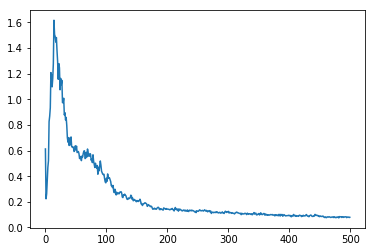

In [500]:
plt.plot(losses)
plt.show()

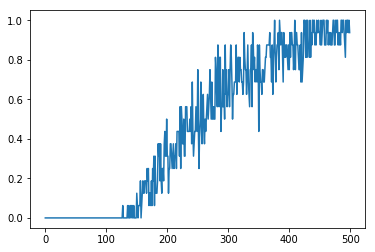

In [501]:
plt.plot(success_rate)
plt.show()

In [502]:
for _ in range(5):
    state, goal = env.reset()
    env.render()
    for t in range(size):
        action = agent.choose_action([state], [goal])
        next_state, reward, done = env.step(action)
        state = next_state
        env.render()
        time.sleep(0.5)
        if done:
            break
    print(done)

state : [1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0] , goal : [1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0]          True
state : [0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1] , goal : [0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1]          True
state : [0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0] , goal : [0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0]          True
state : [0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1] , goal : [0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1]          True
state : [1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0] , goal : [1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0]          True
